In [79]:
!pip install -Uq opencv-python-headless

In [62]:
#
# download sample video file
#
CDN_URL = "https://d2yqlwoly7fl0b.cloudfront.net/super-slomo"

SAMPLE_VIDEO = "westiepoo.mov"
!wget -L {CDN_URL}/samples/{SAMPLE_VIDEO} -O videos/{SAMPLE_VIDEO} --no-check-certificate

--2024-03-03 02:26:32--  https://d2yqlwoly7fl0b.cloudfront.net/super-slomo/samples/westiepoo.mov
Resolving d2yqlwoly7fl0b.cloudfront.net (d2yqlwoly7fl0b.cloudfront.net)... 18.161.3.7, 18.161.3.85, 18.161.3.70, ...
Connecting to d2yqlwoly7fl0b.cloudfront.net (d2yqlwoly7fl0b.cloudfront.net)|18.161.3.7|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 8908629 (8.5M) [video/quicktime]
Saving to: ‘videos/westiepoo.mov’

videos/westiepoo.mo 100%[===================>]   8.50M  --.-KB/s    in 0.05s   

2024-03-03 02:26:32 (173 MB/s) - ‘videos/westiepoo.mov’ saved [8908629/8908629]



In [10]:
# video_path = f"videos/{SAMPLE_VIDEO}"

In [49]:
import boto3
import sagemaker
from sagemaker.utils import name_from_base

sagemaker_session = sagemaker.Session()

bucket = sagemaker_session.default_bucket()
region = sagemaker_session._region_name

prefix = "multi-modal-search"

s3_client = boto3.client('s3')

video_path = 'videos/BigBuckBunny.mp4' #TearsOfSteel.mp4'  #

s3_key = f"{prefix}/{video_path}"
s3_client.upload_file(video_path, bucket, s3_key)

print(f"File uploaded successfully to s3://{bucket}/{s3_key}")

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
File uploaded successfully to s3://sagemaker-us-west-2-374212921621/multi-modal-search/videos/BigBuckBunny.mp4


In [50]:
from helper import video_to_transcription, sample_frames
import pprint as pp
from pathlib import Path
import shutil

video_s3_path = f"s3://{bucket}/{s3_key}"
result = video_to_transcription(video_s3_path, format="wav")

output_dir = Path("frames")
while output_dir.exists():
    shutil.rmtree(output_dir)

output_dir.mkdir(parents=True, exist_ok=False)

output = sample_frames(video_path, result, output_dir, 1)
output

IN_PROGRESS
IN_PROGRESS
IN_PROGRESS
IN_PROGRESS


[{'video': 'BigBuckBunny.mp4',
  'output_file': 'frames/frame_0.jpg',
  'transcript': '',
  'frame_time': 0.0},
 {'video': 'BigBuckBunny.mp4',
  'output_file': 'frames/frame_24.jpg',
  'transcript': '',
  'frame_time': 1.0},
 {'video': 'BigBuckBunny.mp4',
  'output_file': 'frames/frame_48.jpg',
  'transcript': '',
  'frame_time': 2.0},
 {'video': 'BigBuckBunny.mp4',
  'output_file': 'frames/frame_72.jpg',
  'transcript': '',
  'frame_time': 3.0},
 {'video': 'BigBuckBunny.mp4',
  'output_file': 'frames/frame_96.jpg',
  'transcript': '',
  'frame_time': 4.0},
 {'video': 'BigBuckBunny.mp4',
  'output_file': 'frames/frame_120.jpg',
  'transcript': '',
  'frame_time': 5.0},
 {'video': 'BigBuckBunny.mp4',
  'output_file': 'frames/frame_144.jpg',
  'transcript': '',
  'frame_time': 6.0},
 {'video': 'BigBuckBunny.mp4',
  'output_file': 'frames/frame_168.jpg',
  'transcript': '',
  'frame_time': 7.0},
 {'video': 'BigBuckBunny.mp4',
  'output_file': 'frames/frame_192.jpg',
  'transcript': '',
  

In [51]:
from helper import encode_image_to_base64, get_embedding

index_records = []

for frame in output:

    index_record = dict()
    try:
        # upload image to S3
        s3_key = f"{prefix}/{frame['output_file']}"
        s3_client.upload_file(frame["output_file"], bucket, s3_key)

        s3_path = f"s3://{bucket}/{s3_key}"
        print(f"Uploaded {frame['output_file']} to {s3_path}")

        index_record["frame_url"] = s3_path

        # generate embedding
        image_base64 = encode_image_to_base64(frame["output_file"])
        embedding = get_embedding(image_base64=image_base64)

        index_record["multimodal_vector"] = embedding

    except Exception as e:
        print(f"Failed to upload {frame['output_file']}")
        print(e)

    index_records.append({**index_record, **frame})

Uploaded frames/frame_0.jpg to s3://sagemaker-us-west-2-374212921621/multi-modal-search/frames/frame_0.jpg
Uploaded frames/frame_24.jpg to s3://sagemaker-us-west-2-374212921621/multi-modal-search/frames/frame_24.jpg
Uploaded frames/frame_48.jpg to s3://sagemaker-us-west-2-374212921621/multi-modal-search/frames/frame_48.jpg
Uploaded frames/frame_72.jpg to s3://sagemaker-us-west-2-374212921621/multi-modal-search/frames/frame_72.jpg
Uploaded frames/frame_96.jpg to s3://sagemaker-us-west-2-374212921621/multi-modal-search/frames/frame_96.jpg
Uploaded frames/frame_120.jpg to s3://sagemaker-us-west-2-374212921621/multi-modal-search/frames/frame_120.jpg
Uploaded frames/frame_144.jpg to s3://sagemaker-us-west-2-374212921621/multi-modal-search/frames/frame_144.jpg
Uploaded frames/frame_168.jpg to s3://sagemaker-us-west-2-374212921621/multi-modal-search/frames/frame_168.jpg
Uploaded frames/frame_192.jpg to s3://sagemaker-us-west-2-374212921621/multi-modal-search/frames/frame_192.jpg
Uploaded fram

In [52]:
%store -r host
%store -r index_name

In [53]:
from opensearchpy import OpenSearch, RequestsHttpConnection, AWSV4SignerAuth

service = 'aoss'
credentials = boto3.Session().get_credentials()
auth = AWSV4SignerAuth(credentials, region, service)

client = OpenSearch(
    hosts=[{'host': host, 'port': 443}],
    http_auth=auth,
    use_ssl=True,
    verify_certs=True,
    connection_class=RequestsHttpConnection,
    pool_maxsize=20
)

In [54]:
from opensearch_util import bulk_index_ingestion

sucess, failed = bulk_index_ingestion(client, index_name, index_records)

Indexed 597 documents


In [57]:
import json

text = "cute puppy running on green grass"

text_embedding = get_embedding(text_description=text)

query = {
    "size": 5,
    "query": {
        "knn": {
        "multimodal_vector": {
            "vector": text_embedding,
            "k": 5
        }
        }
    },
    "_source": ["video", "transcript", "output_file", "frame_time", "frame_url"]
}


try:
    text_based_search_response = client.search(body=query, index=index_name)
    
    print(json.dumps(text_based_search_response, indent=2))
except Exception as ex:
    print(ex)

{
  "took": 23,
  "timed_out": false,
  "_shards": {
    "total": 0,
    "successful": 0,
    "skipped": 0,
    "failed": 0
  },
  "hits": {
    "total": {
      "value": 24,
      "relation": "eq"
    },
    "max_score": 0.6578158,
    "hits": [
      {
        "_index": "mm-search-2024-03-02-02-00-00-310",
        "_id": "1%3A0%3AE_Dy_I0BGoeDoEsrM7ti",
        "_score": 0.6578158,
        "_source": {
          "transcript": "",
          "video": "westiepoo.mov",
          "output_file": "frames/frame_75.jpg",
          "frame_url": "s3://sagemaker-us-west-2-374212921621/multi-modal-search/frames/frame_75.jpg",
          "frame_time": 3.0
        }
      },
      {
        "_index": "mm-search-2024-03-02-02-00-00-310",
        "_id": "1%3A0%3AEfDy_I0BGoeDoEsrM7ti",
        "_score": 0.6543367,
        "_source": {
          "transcript": "",
          "video": "westiepoo.mov",
          "output_file": "frames/frame_25.jpg",
          "frame_url": "s3://sagemaker-us-west-2-3742129216

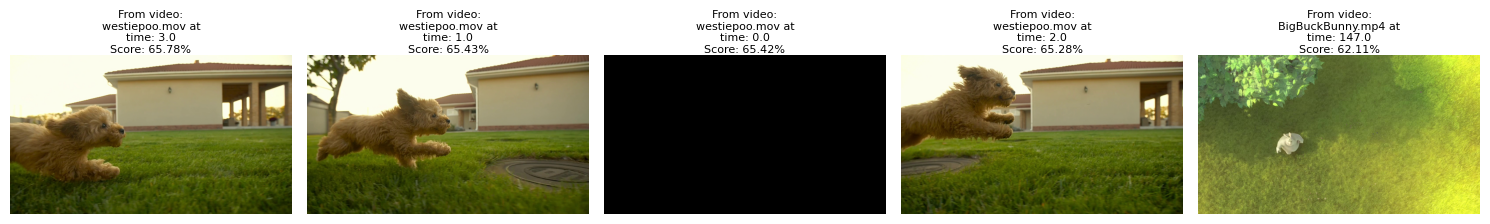

In [59]:
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
import textwrap
from io import BytesIO


# Display images and metadata
rows = 2
columns = 5
fig = plt.figure(figsize=(15, 8))

for index, value in enumerate(text_based_search_response["hits"]["hits"], 1):
    ax = fig.add_subplot(rows, columns, index)
    s3_path = value["_source"]["frame_url"]
    bucket, key = s3_path.split('/', 3)[2:]
    response = s3_client.get_object(Bucket=bucket, Key=key)
    image_content = response['Body'].read()

    image = np.array(Image.open(BytesIO(image_content)))

    # Display the image
    ax.imshow(image)
    ax.axis("off") 

    video = value["_source"]["video"]
    video_time = value["_source"]["frame_time"]
    description = f"From video: {video} at time: {video_time}"
    wrapped_description = "\n".join(textwrap.wrap(description, width=20))
    
    score = f'Score: {value["_score"]:.2%}'
    
    # Set title and description below the image
    title = f'{wrapped_description}\n{score}'
    ax.set_title(title, fontsize=8, pad=2)

plt.tight_layout()
plt.show()

In [60]:
import ipywidgets as ipw
from IPython.display import display, clear_output

class ChatUX:
    """ A chat UX using IPWidgets
    """
    def __init__(self, qa):
        self.qa = qa
        self.name = None
        self.b=None
        self.out = ipw.Output()
        self.session_id = None

    def start_chat(self):
        print("Let's chat!")
        display(self.out)
        self.chat(None)

    def chat(self, _):
        if self.name is None:
            prompt = ""
        else:
            prompt = self.name.value
        if 'q' == prompt or 'quit' == prompt or 'Q' == prompt:
            print("Thank you , that was a nice chat !!")
            return
        elif len(prompt) > 0:
            with self.out:
                thinking = ipw.Label(value=f"Thinking...")
                display(thinking)
                hbox = []
                try:
                    text_embedding = get_embedding(text_description=prompt)
                    query = {
                        "size": 3,
                        "query": {
                            "knn": {
                            "multimodal_vector": {
                                "vector": text_embedding,
                                "k": 5
                            }
                            }
                        },
                        "_source": ["video", "transcript", "output_file", "frame_time", "frame_url"]
                    }
                    response = client.search(body=query, index=index_name)

                    for index, value in enumerate(response["hits"]["hits"], 1):
                        
                        s3_path = value["_source"]["frame_url"]
                        bucket, key = s3_path.split('/', 3)[2:]
                        response = s3_client.get_object(Bucket=bucket, Key=key)
                        image_content = response['Body'].read()

                        image = ipw.Image(value=image_content)


                        video = value["_source"]["video"]
                        video_time = value["_source"]["frame_time"]
                        description = f"From video: {video} at time: {video_time}"
                        wrapped_description = "\n".join(textwrap.wrap(description, width=20))
                        
                        score = f'Score: {value["_score"]:.2%}'
                        
                        # Set title and description below the image
                        title = ipw.Label(f'{wrapped_description}\n{score}')

                        hbox.append(ipw.VBox([title, image]))
                        
                except Exception as e:
                    print(e)
                    result = "No answer"

                thinking.value=""
                print("AI:")
                result = ipw.HBox(hbox)
                display(result)
                self.name.disabled = True
                self.b.disabled = True
                self.name = None

        if self.name is None:
            with self.out:
                self.name = ipw.Text(description="You: ", placeholder='q to quit')
                self.b = ipw.Button(description="Send")
                self.b.on_click(self.chat)
                display(ipw.Box(children=(self.name, self.b)))

In [ ]:
agent_runtime_client = boto3.client('bedrock-runtime')

chat = ChatUX(agent_runtime_client)
chat.start_chat()